# Height Data

In [1]:
using Distributions
using StatisticalRethinking
using DataFrames
using CSV
using ForwardDiff

include("lahmc.jl")
include("run_lahmc.jl")

sample_loop (generic function with 1 method)

In [2]:
howell = CSV.read(sr_datadir("Howell1.csv"), DataFrame)
howell = howell[howell.age .>= 18,:]
first(howell, 5)

Row,height,weight,age,male
,Float64,Float64,Float64,Int64
1,151.765,47.8256,63.0,1
2,139.7,36.4858,63.0,0
3,136.525,31.8648,65.0,0
4,156.845,53.0419,41.0,1
5,145.415,41.2769,51.0,0


In [3]:
describe(howell, :all)
# size(howell)

Row,variable,mean,std,min,q25,median,q75,max,sum,nunique,nuniqueall,nmissing,nnonmissing,first,last,eltype
,Symbol,Float64,Float64,Real,Float64,Float64,Float64,Real,Real,Nothing,Int64,Int64,Int64,Real,Real,DataType
1,height,154.597,7.74233,136.525,148.59,154.305,160.655,179.07,54418.2,,81,0,352,151.765,158.75,Float64
2,weight,44.9905,6.45671,31.0711,40.2563,44.7922,49.2927,62.9926,15836.7,,289,0,352,47.8256,52.5316,Float64
3,age,41.1385,15.9679,18.0,28.0,39.0,51.0,88.0,14480.8,,77,0,352,63.0,68.0,Float64
4,male,0.46875,0.499733,0,0.0,0.0,1.0,1,165,,2,0,352,1,1,Int64


In [4]:
xbar = mean(howell.weight)
n = nrow(howell)

function U(X)
    a = X[1]
    b = X[2]
    sigma = X[3]
    return -(sum(logpdf(Normal((a + b*(howell[i, :].weight - xbar)), sigma), 
        howell[i, :].height) for i in 1:n) 
        + logpdf(Normal(178, 20), a) + logpdf(LogNormal(0,1), b) + logpdf(Uniform(0, 50), sigma))  
end

# function dU(X)
#     a = X[1]
#     b = X[2]
#     sigma = X[3]
#     da = -(a - 178)/(20^2) + sum(howell[i, :].height - 
#         (a + b*(howell[i, :].weight - xbar))/(sigma^2) for i in 1:n)

#     db = -(b)/(10^2) + sum((howell[i, :].weight - xbar)*(howell[i, :].height 
#             - (a + b*(howell[i, :].weight - xbar)))/(sigma^2) for i in 1:n)

#     dsigma = -(n+1)/(sigma) + sum(((howell[i, :].height 
#         - (a + b*(howell[i, :].weight - xbar)))^2)/(sigma^3) for i in 1:n)
    
#     return [-da, -db, -dsigma]
# end

function dU(X)
    return ForwardDiff.gradient(U, [X[1], X[2], X[3]])
end

function init_q()
    init_sample = [155, 0.5, 25]
    accepted_sample = burn_in!(LAHMC(U, dU, init_sample, epsilon, L, 1, beta, n_samples))
    return accepted_sample
end

# return -(sum([logpdf(Normal((a + b*(howell[i, :].weight - xbar)), sigma), 
    #     howell[i, :].height) for i in 1:1]) 
    #     + logpdf(Normal(178, 20), a) + logpdf(Normal(0,10), b) + logpdf(Uniform(0, 50), sigma))

# LogNormal beta
    # db = -(2*X[2])/(log(1/(10*sqrt(2*pi)))-X[2]^2) + sum([(howell[i, :].weight - xbar)*(howell[i, :].height 
    #     - (X[1] + X[2]*(howell[i, :].weight - xbar)))/(X[3]^2) for i in 1:n])

# da = -(a - 178)/(20^2) + sum([howell[i, :].height - 
    #     (a + b*(howell[i, :].weight - xbar))/(sigma^2) for i in 1:1])

    # db = -(b)/(10^2) + sum([(howell[i, :].weight - xbar)*(howell[i, :].height 
    #         - (a + b*(howell[i, :].weight - xbar)))/(sigma^2) for i in 1:1])

    # # LogNormal beta
    # # db = -(2*X[2])/(log(1/(10*sqrt(2*pi)))-X[2]^2) + sum([(howell[i, :].weight - xbar)*(howell[i, :].height 
    # #     - (X[1] + X[2]*(howell[i, :].weight - xbar)))/(X[3]^2) for i in 1:1])

    # dsigma = -(n+1)/sigma + sum([((howell[i, :].height 
    #     - (a + b*(howell[i, :].weight - xbar)))^2)/(sigma^3) for i in 1:1])

init_q (generic function with 1 method)

In [5]:
n_samples = 1000
n_chains = 1
epsilon = 0.01
L = 10
beta = 1
n_param = 3

lahmc_samples, grad_count = sample_loop(n_chains, U, dU, init_q, epsilon, L, 4, beta, n_param, n_samples)
# autocorrelation_lahmc = calculate_looped_autocorrelation(lahmc_samples)

# gradient_evaluations_lahmc = LinRange(0, grad_count/n_chains, length(autocorrelation_lahmc))

# plt_lahmc_ac = plot(gradient_evaluations_lahmc, autocorrelation_lahmc, title="Gradient Evaluations vs Autocorrelation", xlabel="Gradient Evaluations", ylabel="Autocorrelation", label="LAHMC")

# hmc_samples, grad_count = sample_loop(n_chains, U, dU, init_q, epsilon, L, 1, beta, n_param, n_samples)
# autocorrelation_hmc = calculate_looped_autocorrelation(hmc_samples)

Accepted sample found after 5 iterations.
Average acceptance rate: 1.0
Average transition rates: L1: 0.998998998998999 L2: 0.0 L3: 0.0 L4: 0.001001001001001001 F: 0.0


([155.1330204509088; 0.7218503020964642; 25.022247677724415;;; 155.1538590795345; 0.7278316237282788; 24.92145297557689;;; 155.4195454181936; 0.8682114421922877; 24.744823007629716;;; … ;;; 154.5502396065527; 0.877527768058774; 5.181594075989299;;; 154.62784281074232; 0.9312313911824333; 5.184278051740621;;; 154.59387608304002; 0.860329875085929; 5.184735255631011], 10020)

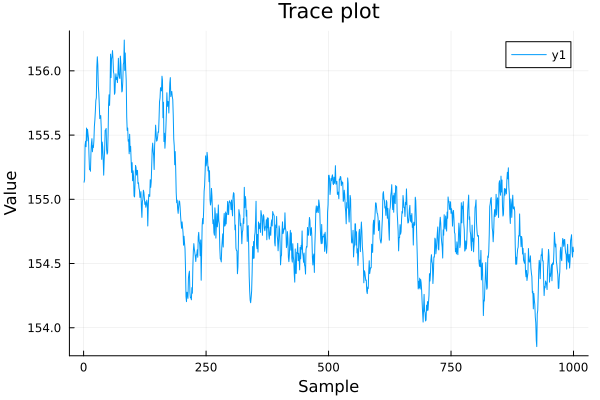

In [6]:
plot(lahmc_samples[1, 1, :], title="Trace plot", xlabel="Sample", ylabel="Value")

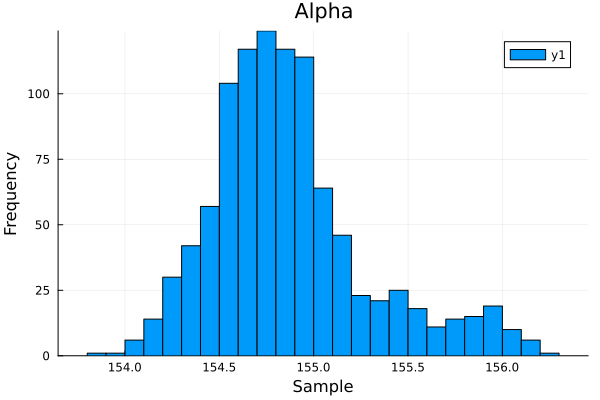

In [7]:
alpha_post = histogram(lahmc_samples[1, 1, :], bin_width=0.01, title="Alpha", xlabel="Sample", ylabel="Frequency")

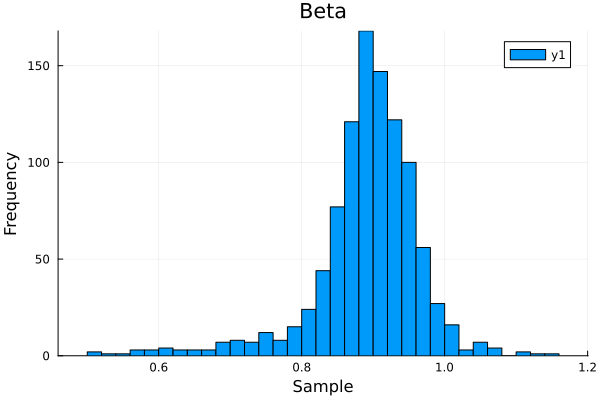

In [8]:
beta_post = histogram(lahmc_samples[2, 1, :], bin_width=0.2, title="Beta", xlabel="Sample", ylabel="Frequency")

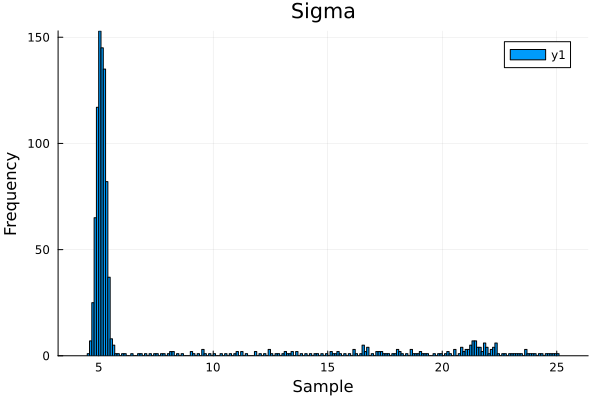

In [9]:
sigma_post = histogram(lahmc_samples[3, 1, :], bin_width=0.05, title="Sigma", xlabel="Sample", ylabel="Frequency")

In [10]:
df_post = DataFrame(lahmc_samples[:, 1, :]', :auto)
rename!(df_post,[:a, :b, :sigma])
first(df_post, 5)

Row,a,b,sigma
,Float64,Float64,Float64
1,155.133,0.72185,25.0222
2,155.154,0.727832,24.9215
3,155.42,0.868211,24.7448
4,155.452,0.67786,24.8573
5,155.409,0.70887,24.5837


In [11]:
describe(df_post)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,a,154.868,153.853,154.803,156.24,0,Float64
2,b,0.891309,0.514059,0.897823,1.14744,0,Float64
3,sigma,7.82206,4.58737,5.19228,25.0222,0,Float64


In [13]:
round.(cov(lahmc_samples[:, 1, :]'), digits=3)

3×3 Matrix{Float64}:
  0.174  -0.01    1.732
 -0.01    0.006  -0.148
  1.732  -0.148  31.831

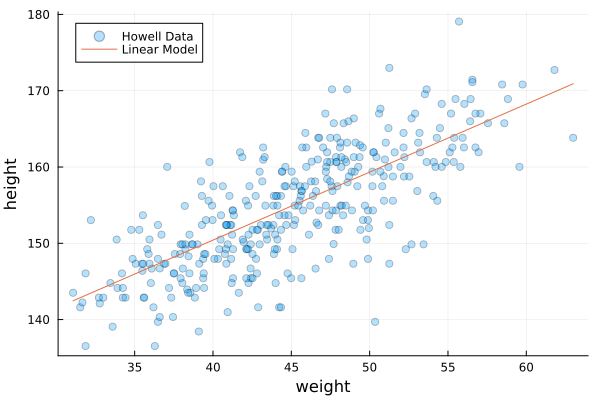

In [22]:
p = scatter(howell.weight, howell.height; alpha=0.3, xlabel="weight", ylabel="height", label="Howell Data")

a_mean = mean(lahmc_samples[1, 1, :])
b_mean = mean(lahmc_samples[2, 1, :])
plot!(x -> a_mean + b_mean*(x-xbar), alpha=1, label="Linear Model")